In [18]:
import pandas as pd
import keras as kr
import numpy as np
import matplotlib.pyplot as plt 

In [19]:
# Read data from excel file
kumpula   = pd.read_excel('Wind_speed_Kumpula_Sodankyla_2008.xlsx', usecols=[3, 4], skiprows=[0], header=[0], names=['Temp', 'Wind'])
sodankylä = pd.read_excel('Wind_speed_Kumpula_Sodankyla_2008.xlsx', usecols=[5, 6], skiprows=[0], header=[0], names=['Temp', 'Wind'])

# Create a flattened version with previous values in same row
start = 1
end = 5
step = 1
forecastStep = 1

for i in range(start, end, step):
    newColumnTemp = 'Temp-' + str(i)
    newColumnWind = 'Wind-' + str(i)
    kumpula  [newColumnTemp] = kumpula  .Temp.shift(i)
    sodankylä[newColumnTemp] = sodankylä.Temp.shift(i)
    kumpula  [newColumnWind] = kumpula  .Wind.shift(i)
    sodankylä[newColumnWind] = sodankylä.Wind.shift(i)

# Create "target" variable
kumpula  ['Wind Target'] = kumpula  ['Wind'].shift(-1 * forecastStep)
sodankylä['Wind Target'] = sodankylä['Wind'].shift(-1 * forecastStep)

# Drop rows that have no values due to shifting (creating variables)
indexesToDrop = list(range(start-1, end-1))
indexesToDrop.append(len(kumpula)-1)
kumpula  .drop(index=indexesToDrop, inplace=True)
sodankylä.drop(index=indexesToDrop, inplace=True)

# Reindex
kumpula  .reset_index(drop=True, inplace=True)
sodankylä.reset_index(drop=True, inplace=True)

In [20]:
def plot_costs(costs):
    plt.figure()
    plt.plot(np.arange(len(costs)), costs)
    plt.title('Costs mean squared error')
    plt.xlabel('Epochs'), plt.ylabel('Cost')


In [21]:
# Create validation- and training sets as well as X- and Y-pairs
kumpulaTraining   = kumpula  .sample(frac=0.8, random_state=2018)
sodankyläTraining = sodankylä.sample(frac=0.8, random_state=2018)

kumpulaTrainingX,   kumpulaTrainingY   = kumpulaTraining  .iloc[:, 0:10], kumpulaTraining  .iloc[:, 10]
sodankyläTrainingX, sodankyläTrainingY = sodankyläTraining.iloc[:, 0:10], sodankyläTraining.iloc[:, 10]
 
kumpulaValidation   = kumpula  [kumpula  .index.isin(kumpulaTraining.  index) == False]
sodankyläValidation = sodankylä[sodankylä.index.isin(sodankyläTraining.index) == False]

kumpulaValidationX,   kumpulaValidationY   = kumpulaValidation  .iloc[:, 0:10], kumpulaValidation  .iloc[:, 10]
sodankyläValidationX, sodankyläValidationY = sodankyläValidation.iloc[:, 0:10], sodankyläValidation.iloc[:, 10]

# Also want to try out combinin the datasets, maybe it has a regularizing effect?
combinedTraining   = kumpulaTraining  .append(sodankyläTraining)
combinedValidation = kumpulaValidation.append(sodankyläValidation)

combinedTrainingX,   combinedTrainingY   = combinedTraining  .iloc[:, 0:10], combinedTraining  .iloc[:, 10]
combinedValidationX, combinedValidationY = combinedValidation.iloc[:, 0:10], combinedValidation.iloc[:, 10]

In [22]:
# Model for Kumpula
X_t, Y_t, X_v, Y_v = kumpulaTrainingX.values, kumpulaTrainingY.values, kumpulaValidationX.values, kumpulaValidationY.values

KumpulaModel = kr.models.Sequential()
KumpulaModel.add(kr.layers.Dense(16, input_dim=2 * (end - start + 1), activation='relu'))
KumpulaModel.add(kr.layers.Dense(1, activation='linear'))

KumpulaModel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history_kumpula = KumpulaModel.fit(X_t, Y_t, epochs=75, batch_size=256)

scores = KumpulaModel.evaluate(X_v, Y_v)
print("\n%s: %.2f%%" % (KumpulaModel.metrics_names[1], scores[1]*100))

Epoch 1/75
7023/7023 [==============================] - 0s 41us/step - loss: 81.9142 - acc: 0.0000e+00
Epoch 2/75
7023/7023 [==============================] - 0s 51us/step - loss: 20.2550 - acc: 0.0093
Epoch 3/75
7023/7023 [==============================] - 0s 43us/step - loss: 9.3991 - acc: 0.0128
Epoch 4/75
7023/7023 [==============================] - 0s 41us/step - loss: 5.3703 - acc: 0.0175
Epoch 5/75
7023/7023 [==============================] - 0s 43us/step - loss: 3.2642 - acc: 0.0242
Epoch 6/75
7023/7023 [==============================] - 0s 41us/step - loss: 2.3653 - acc: 0.0299
Epoch 7/75
7023/7023 [==============================] - 0s 49us/step - loss: 2.0329 - acc: 0.0330
Epoch 8/75
7023/7023 [==============================] - 0s 38us/step - loss: 1.8855 - acc: 0.0330
Epoch 9/75
7023/7023 [==============================] - 0s 37us/step - loss: 1.7988 - acc: 0.0345
Epoch 10/75
7023/7023 [==============================] - 0s 45us/step - loss: 1.7393 - acc: 0.0356
Epoch 11/75
7

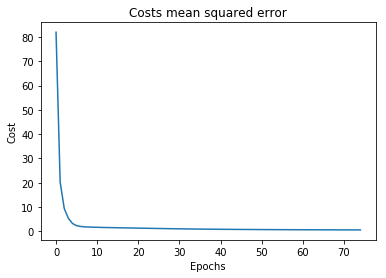

In [23]:
plot_costs(history_kumpula.history['loss'])

In [24]:
# Model for Sodankylä
X_t, Y_t, X_v, Y_v = sodankyläTrainingX.values, sodankyläTrainingY.values, sodankyläValidationX.values, sodankyläValidationY.values

SodankyläModel = kr.models.Sequential()
SodankyläModel.add(kr.layers.Dense(16, input_dim=2 * (end - start + 1), activation='relu'))
SodankyläModel.add(kr.layers.Dense(1, activation='linear'))

SodankyläModel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history_sodankylä = SodankyläModel.fit(X_t, Y_t, epochs=75, batch_size=256)

scores = SodankyläModel.evaluate(X_v, Y_v)
print("\n%s: %.2f%%" % (SodankyläModel.metrics_names[1], scores[1]*100))

Epoch 1/75
7023/7023 [==============================] - 0s 30us/step - loss: 52.6567 - acc: 0.0038
Epoch 2/75
7023/7023 [==============================] - 0s 30us/step - loss: 11.9072 - acc: 0.0204
Epoch 3/75
7023/7023 [==============================] - 0s 27us/step - loss: 3.8619 - acc: 0.0263
Epoch 4/75
7023/7023 [==============================] - 0s 36us/step - loss: 2.6084 - acc: 0.0316
Epoch 5/75
7023/7023 [==============================] - 0s 29us/step - loss: 1.8705 - acc: 0.0325
Epoch 6/75
7023/7023 [==============================] - 0s 46us/step - loss: 1.4101 - acc: 0.0367
Epoch 7/75
7023/7023 [==============================] - 0s 26us/step - loss: 1.1290 - acc: 0.0423
Epoch 8/75
7023/7023 [==============================] - 0s 28us/step - loss: 0.9361 - acc: 0.0481
Epoch 9/75
7023/7023 [==============================] - 0s 29us/step - loss: 0.8362 - acc: 0.0524
Epoch 10/75
7023/7023 [==============================] - 0s 35us/step - loss: 0.7745 - acc: 0.0555
Epoch 11/75
7023/

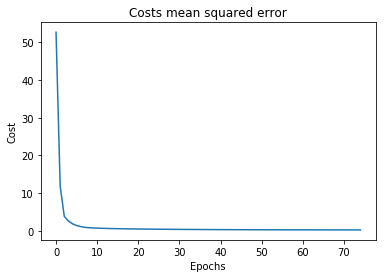

In [25]:
plot_costs(history_sodankylä.history['loss'])

In [26]:
# Model for Combined
X_t, Y_t, X_v, Y_v = combinedTrainingX.values, combinedTrainingY.values, combinedValidationX.values, combinedValidationY.values

CombinedModel = kr.models.Sequential()
CombinedModel.add(kr.layers.Dense(16, input_dim=2 * (end - start + 1), activation='relu'))
CombinedModel.add(kr.layers.Dense(1, activation='linear'))

CombinedModel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history_combined = CombinedModel.fit(X_t, Y_t, epochs=75, batch_size=256)
scores = CombinedModel.evaluate(X_v, Y_v)
print("\n%s: %.2f%%" % (CombinedModel.metrics_names[1], scores[1]*100))

Epoch 1/75
14046/14046 [==============================] - 0s 19us/step - loss: 1.7816 - acc: 0.0388
Epoch 2/75
14046/14046 [==============================] - 1s 43us/step - loss: 1.0352 - acc: 0.0482
Epoch 3/75
14046/14046 [==============================] - 1s 46us/step - loss: 0.8446 - acc: 0.0530
Epoch 4/75
14046/14046 [==============================] - 1s 46us/step - loss: 0.7323 - acc: 0.0542: 0s - loss: 0.7844 - acc
Epoch 5/75
14046/14046 [==============================] - 1s 43us/step - loss: 0.6603 - acc: 0.0567
Epoch 6/75
14046/14046 [==============================] - 0s 32us/step - loss: 0.6120 - acc: 0.0578
Epoch 7/75
14046/14046 [==============================] - 0s 25us/step - loss: 0.5733 - acc: 0.0588
Epoch 8/75
14046/14046 [==============================] - 1s 56us/step - loss: 0.5390 - acc: 0.0602
Epoch 9/75
14046/14046 [==============================] - 1s 39us/step - loss: 0.5130 - acc: 0.0607
Epoch 10/75
14046/14046 [==============================] - 1s 50us/step - l

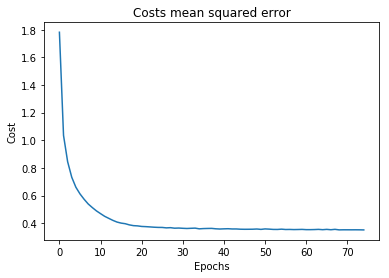

In [27]:
plot_costs(history_combined.history['loss'])

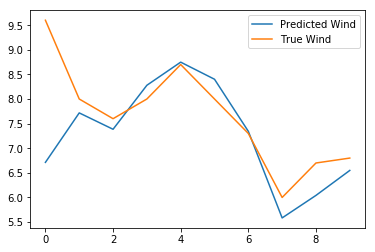

In [30]:
n = 10
preds = CombinedModel.predict(X_v).flatten()[:n]
plt.plot(np.arange(len(preds)), preds, label='Predicted Wind')
plt.plot(np.arange(n), Y_v[:n], label='True Wind')
plt.legend()
plt.show()